In [44]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns

# Statistical analysis
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

# Machine learning - XGBoost
import xgboost as xgb

# Machine learning - Unsupervised learning
from sklearn import decomposition
from pca import pca
from sklearn import cluster
from sklearn import neighbors as nb

# Machine learning - Autoencoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input
from plot_keras_history import show_history, plot_history


In [4]:
# Load data
DATA_PATH = "../data/raw/data_ml.csv"
data_ml = pd.read_csv(DATA_PATH)
data_ml['date'] = pd.to_datetime(data_ml['date'])
data_ml['R1M_Usd_C'] = (data_ml['R1M_Usd'] > 0).astype(int) # for classification

In [25]:
# Recreate variables done in notebooks 4 and 5
X = data_ml.iloc[:,3:95] # recall features/predictors, full sample
y = data_ml['R1M_Usd'] # recall label/Dependent variable, full sample

features = X.columns.values.tolist()
features_short = ["Div_Yld", "Eps", "Mkt_Cap_12M_Usd", "Mom_11M_Usd", "Ocf", "Pb", "Vol1Y_Usd"]
separation_date = pd.to_datetime('2013-01-01')
training_sample = data_ml.loc[data_ml['date'] < separation_date]
testing_sample = data_ml.loc[data_ml['date'] > separation_date]


X_short = data_ml[features_short]
X_short_train = training_sample[features_short]
y_short_train = training_sample['R1M_Usd'].values
X_short_test = testing_sample[features_short]
y_short_test = testing_sample['R1M_Usd'].values


y_train = training_sample['R1M_Usd'].values # regression target
X_train = training_sample[features]
X_test = testing_sample[features]
y_test = testing_sample['R1M_Usd'].values

# For XGBoost model
separation_mask = data_ml['date'] < separation_date
data_ml['R1M_Usd_quantile'] = data_ml.groupby('date')['R1M_Usd'].transform(         # creating quantile... 
        lambda x: pd.qcut(x, 100, labels=False, duplicates=('drop'), precision=50)) # ...for selecting extreme values
boolean_quantile=(data_ml.loc[separation_mask]['R1M_Usd_quantile'].        # boolean array for selecting rows
                  values<=0.2) | (data_ml.loc[separation_mask]['R1M_Usd_quantile'].values>=0.8) # selecting extreme values
train_features_xgb=training_sample.loc[boolean_quantile,features_short] # Independent variables
train_label_xgb=training_sample.loc[boolean_quantile,'R1M_Usd'] # Dependent variable
train_matrix_xgb=xgb.DMatrix(train_features_xgb, label=train_label_xgb) # XGB format!

y_penalized = data_ml['R1M_Usd'].values # Dependent variable
X_penalized = data_ml[features].values # Predictors
y_penalized_train = training_sample['R1M_Usd'].values # Dependent variable
X_penalized_train = training_sample[features].values # Predictors

# Chapter 15 Unsupervised learning
## 15.1 The problem with correlated predictors

In [6]:
stat = sm.OLS(training_sample['R1M_Usd'],sm.add_constant(training_sample[features])).fit()  # Model: predict R1M_Usd
reg_thrhld=3                                                                                # Keep significant predictors only
boo_filter = np.abs(stat.tvalues) >= reg_thrhld                                             # regressors significance threshold
estimate=stat.params[boo_filter]                                                            # estimate
std_error=stat.bse[boo_filter]                                                              # std.error
statistic=stat.tvalues[boo_filter]                                                          # statistic
p_value=stat.pvalues[boo_filter]                                                            # p.value
significant_regressors = pd.concat([estimate,std_error,statistic,p_value],axis=1)           # Put output in clean format
significant_regressors.columns=['estimate','std.error','statistic','p.value']               # Renaming columns
print(significant_regressors)

                   estimate  std.error  statistic       p.value
const              0.043656   0.005419   8.055504  7.958978e-16
Ebitda_Margin      0.013647   0.003513   3.884684  1.024967e-04
Eps               -0.032147   0.010621  -3.026867  2.471347e-03
Fcf                0.014458   0.004158   3.477512  5.061996e-04
Fcf_Bv             0.029046   0.005242   5.540856  3.013807e-08
Fcf_Yld           -0.014058   0.003818  -3.682386  2.311230e-04
Mkt_Cap_12M_Usd    0.218750   0.022187   9.859421  6.317741e-23
Mkt_Cap_6M_Usd    -0.192664   0.043462  -4.432892  9.302782e-06
Mom_5M_Usd        -0.020293   0.004598  -4.413788  1.016313e-05
Mom_Sharp_11M_Usd  0.020842   0.004892   4.260659  2.039200e-05
Mom_Sharp_5M_Usd   0.015544   0.004617   3.366600  7.611556e-04
Ni                 0.015851   0.004583   3.458444  5.434201e-04
Ni_Avail_Margin    0.017203   0.004421   3.890705  9.998609e-05
Ocf_Bv            -0.021673   0.005365  -4.039471  5.359209e-05
Pb                -0.017501   0.003164  

<Axes: >

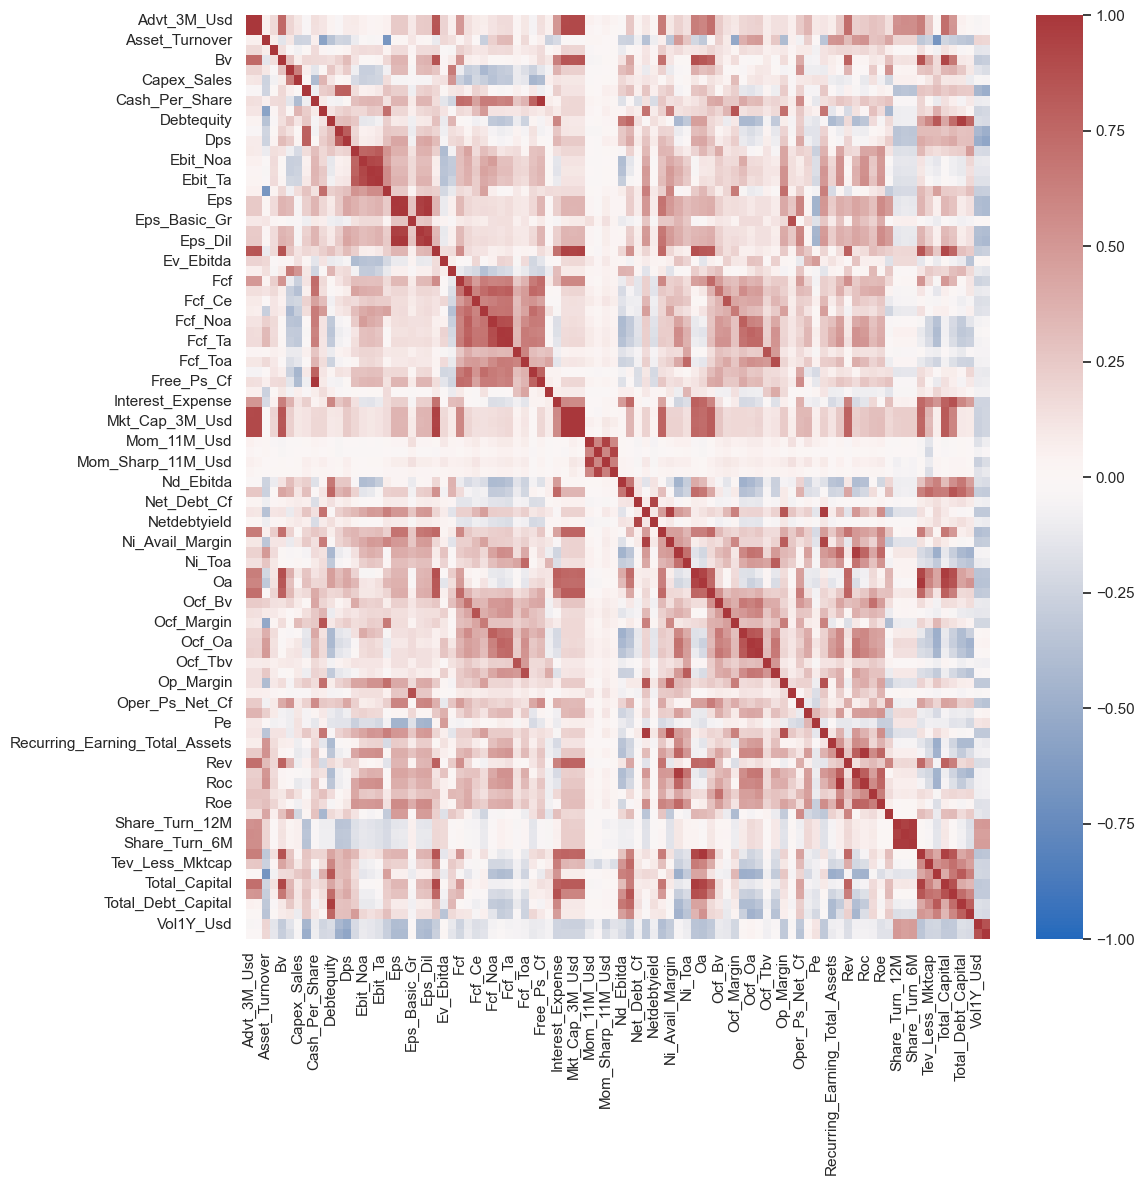

In [7]:
sns.set(rc={'figure.figsize':(12,12)})                                               # Setting the figsize in seaborn 
sns.heatmap(training_sample[features].corr(), vmin=-1, vmax=1, cmap="vlag")      # Correlation matrix and plot

## 15.2 Principal component analysis and autoencoders
### 15.2.2 PCA

In [10]:
pca = decomposition.PCA(n_components=7)                             # we impose the number of components
pca.fit(training_sample[features_short])                            # Performs PCA on smaller number of predictors
print(pca.explained_variance_ratio_)                                # Cheking the variance explained per component

P=pd.DataFrame(pca.components_,columns=features_short).T            # Rotation (n x k) = (7 x 7)
P.columns = ['P' + str(col)  for col in P.columns]                  # tidying up columns names
P

[0.35508778 0.1988301  0.15595962 0.10205266 0.09524267 0.06957294
 0.02325423]


,P0,P1,P2,P3,P4,P5,P6
Div_Yld,0.280597,-0.562316,-0.052692,0.543869,-0.228119,0.503592,0.029208
Eps,0.421905,-0.162279,0.001230,-0.339504,0.768989,0.298233,0.010489
Mkt_Cap_12M_Usd,0.520817,0.356297,-0.166179,-0.060021,-0.247190,0.001713,0.713778
Mom_11M_Usd,0.054946,0.049266,0.896858,-0.243336,-0.234776,0.272266,0.041698
Ocf,0.532211,0.203983,-0.181964,-0.233344,-0.358386,0.041079,-0.676354
Pb,0.144723,0.583619,0.225500,0.669258,0.329197,0.031073,-0.174217
Vol1Y_Usd,-0.405955,0.381931,-0.285116,-0.154186,-0.059869,0.762015,0.003655


[16-02-2026 09:38:04] [pca.pca] [INFO] Extracting row labels from dataframe.
[16-02-2026 09:38:04] [pca.pca] [INFO] The PCA reduction is performed on 7 variables (columns) of the input dataframe.
[16-02-2026 09:38:04] [pca.pca] [INFO] Fit using PCA.
[16-02-2026 09:38:04] [pca.pca] [INFO] Compute loadings and PCs.
[16-02-2026 09:38:04] [pca.pca] [INFO] Compute explained variance.
[16-02-2026 09:38:04] [pca.pca] [INFO] Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[7]
[16-02-2026 09:38:40] [pca.pca] [INFO] Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[16-02-2026 09:38:40] [pca.pca] [INFO] Outlier detection using SPE/DmodX with n_std=[3]
[16-02-2026 09:39:13] [pca.pca] [INFO] Plot PC1 vs PC2 with loadings.
[16-02-2026 09:39:13] [scatterd.scatterd] [INFO] Create scatterplot


(<Figure size 2500x1500 with 1 Axes>,
 <Axes: title={'center': 'The top 7 Principal Component(s) explains [99.99%] of the variance.'}, xlabel='PC1 (35.5% expl.var)', ylabel='PC2 (19.8% expl.var)'>)

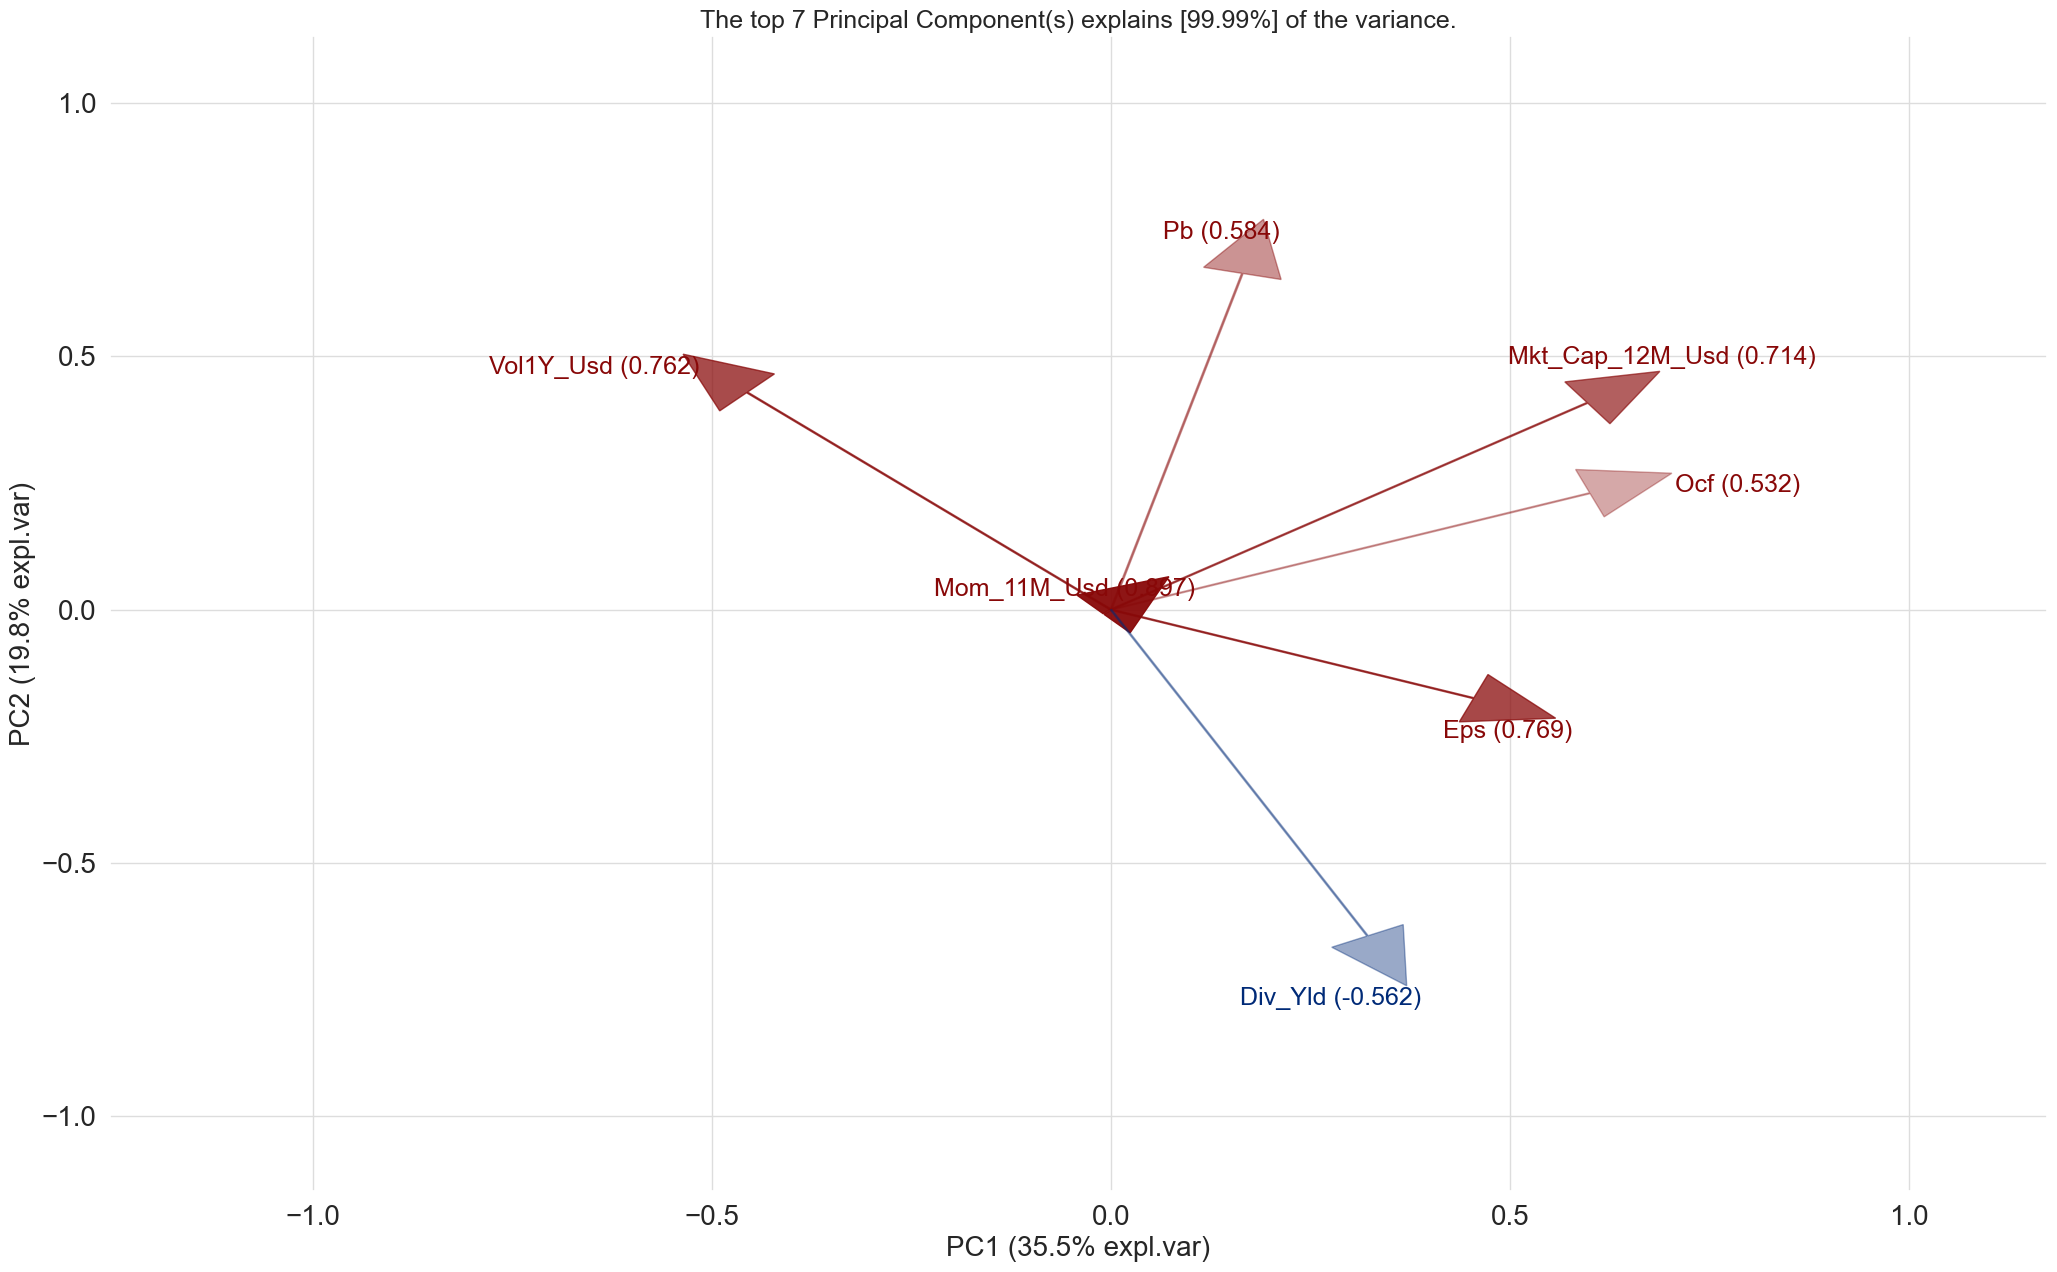

In [15]:
model = pca(n_components=7)                                                               # Initialize
results = model.fit_transform(training_sample[features_short], col_labels=features_short) # Fit transform and include the column labels and row labels
model.biplot(n_feat=7, PC=[0,1],cmap=None, label=None, legend=False)                      # Make biplot

In [16]:
pd.DataFrame(                                                   # Using DataFrame format
    np.matmul(                                                  # Matrix product using numpy                    
    training_sample[features_short].values,P.values[:, :4]),    # Matrix values
    columns=['PC1','PC2','PC3','PC4']                           # Change column names
    ).head()                                                    # Show first 5 lines

,PC1,PC2,PC3,PC4
0,-0.032725,0.561567,-0.033287,0.273561
1,-0.068045,0.627567,-0.053870,0.215597
2,-0.070129,0.655109,0.062002,0.170865
3,-0.074796,0.503482,-0.210365,0.373630
4,-0.115528,0.558704,-0.192276,0.312571


### 15.2.3 Autoencoders

In [28]:
input_layer = Input(shape=(7,))                                               # features_short has 7 columns 
encoder = tf.keras.layers.Dense(units=32, activation="sigmoid")(input_layer)  # First, encode
encoder = tf.keras.layers.Dense(units=4)(encoder)                             # 4 dimensions for the output layer (same as PCA example)
decoder = tf.keras.layers.Dense(units=32, activation="sigmoid")(encoder)      # Then, from encoder, decode
decoder = tf.keras.layers.Dense(units=7)(decoder)                             # the original sample has 7 features

In [29]:
ae_model = keras.Model(input_layer, decoder)      # Builds the model
ae_model.compile(                                 # Learning parameters
    optimizer='adam', 
    loss='mean_squared_error', 
    metrics=['mean_squared_error'])

Epoch 1/15
385/385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1880 - mean_squared_error: 0.1880 - val_loss: 0.0726 - val_mean_squared_error: 0.0726
Epoch 2/15
385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0603 - mean_squared_error: 0.0603 - val_loss: 0.0480 - val_mean_squared_error: 0.0480
Epoch 3/15
385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0449 - mean_squared_error: 0.0449 - val_loss: 0.0362 - val_mean_squared_error: 0.0362
Epoch 4/15
385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0301 - mean_squared_error: 0.0301 - val_loss: 0.0251 - val_mean_squared_error: 0.0251
Epoch 5/15
385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0196 - val_mean_squared_error: 0.0196
Epoch 6/15
385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0179 - mean_squared_error: 0.0179 - val_loss: 0.0168 - val_mean_squared_error: 0.0168
Epoch 7/15
385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0167 - mean_squared_error: 0.0167 - val_loss: 0.01

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <Axes: title={'center': 'MSE'}, xlabel='Epochs', ylabel='MSE'>],
       dtype=object))

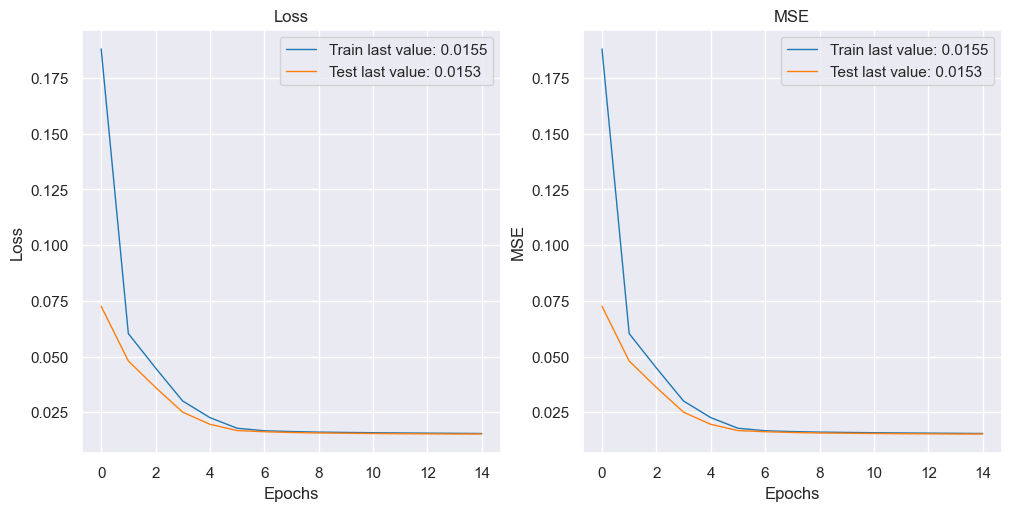

In [30]:
history=ae_model.fit(X_short_train, # Input
                     X_short_train, # Output
                epochs=15,
                batch_size=512,
                validation_data=(X_short_test, X_short_test))
plot_history(history)

In [33]:
ae_weights=ae_model.get_weights()

## 15.3 Clustering via k-means

In [35]:
k_means = cluster.KMeans(n_clusters=10)                                                     # setting the number of cluster
k_means.fit(training_sample[features].T)                                                    # Performs the k-means clustering
clusters = pd.DataFrame([features, k_means.labels_],index=["factor", "cluster"]).T          # Organize the cluster data
clusters.loc[clusters['cluster']==4,:]                                                      # Shows one particular group   

,factor,cluster
70,Pe,4
80,Share_Turn_12M,4
81,Share_Turn_3M,4
82,Share_Turn_6M,4
90,Vol1Y_Usd,4
91,Vol3Y_Usd,4


## 15.4 Nearest neighbors

In [37]:
knn_data = data_ml.loc[data_ml['date']=='2006-12-31',:]          # Dataset for k-NN exercise
knn_target = knn_data.loc[knn_data['stock_id'] == 13, features]  # Target observation
knn_sample = knn_data.loc[knn_data['stock_id'] != 13, features]  # All other observations
neighbors = nb.NearestNeighbors(n_neighbors=30)       # Number of neighbors to use
neighbors.fit(knn_sample)

,n_neighbors,30
,radius,1.0
,algorithm,'auto'
,leaf_size,30
,metric,'minkowski'
,p,2
,metric_params,None
,n_jobs,None


In [38]:
neigh_dist, neigh_ind = neighbors.kneighbors(knn_target)
print(pd.DataFrame(neigh_ind))  

   0   1    2   3    4    5   6    7   8    9   ...   20  21   22   23   24  \
0   9   8  185  99  294  266  21  180  23  191  ...  310  95  165  215  268   

    25   26   27   28  29  
0  194  548  103  539  17  

[1 rows x 30 columns]


In [39]:
knn_labels = knn_data.loc[:, 'R1M_Usd'].values[neigh_ind]                   # y values for neigh_ind
np.sum(knn_labels * np.exp(-neigh_dist)/np.sum(np.exp(-neigh_dist)))        # Pred w. k(z)=e^(-z)

np.float64(0.03161292361829914)

In [40]:
knn_data.loc[knn_data['stock_id'] == 13, 'R1M_Usd']                         # True y

0    0.089
Name: R1M_Usd, dtype: float64

## 15.5 Coding exercices
Code the compressed version of the data (narrow training sample) via the encoder part of the autoencoder.

In [43]:
# Create encoder model from the trained autoencoder
encoder_model = keras.Model(inputs=ae_model.input, outputs=ae_model.layers[2].output)

# Compress the narrow training sample using the encoder
X_short_train_compressed = encoder_model.predict(X_short_train)

print(f"Original training data shape: {X_short_train.shape}")
print(f"Compressed training data shape: {X_short_train_compressed.shape}")
X_short_train_compressed

6152/6152 ━━━━━━━━━━━━━━━━━━━━ 6s 889us/step
Original training data shape: (196846, 7)
Compressed training data shape: (196846, 4)


array([[ 0.22941403,  0.73168933,  0.24669532, -0.6848245 ],
       [ 0.23892207,  0.72209483,  0.24140343, -0.68886405],
       [ 0.23441726,  0.73271155,  0.22915865, -0.68864894],
       ...,
       [ 0.21070415,  0.75752777,  0.11019519, -0.56227875],
       [ 0.19874068,  0.76632667,  0.12223719, -0.5557966 ],
       [ 0.18836364,  0.8102082 ,  0.20809372, -0.7350968 ]],
      shape=(196846, 4), dtype=float32)